In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 시멘틱 세그멘테이션

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 사진1: 인물 사진

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1242, 1242, 3)


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1242, 1242, 3) (513, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

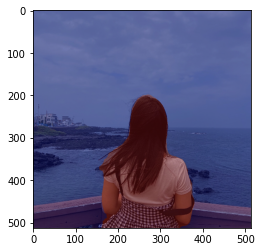

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

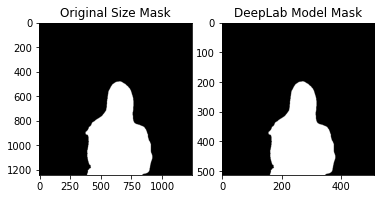

In [8]:
# 세그멘테이션 결과를 원래 크기로 복원하기
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


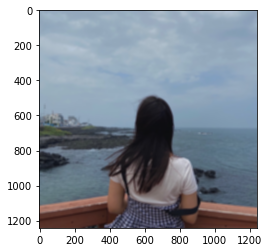

In [9]:
# 배경흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

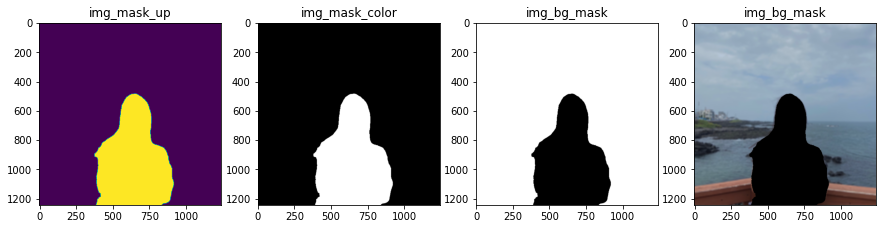

In [10]:
# 마스크 과정 보기
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

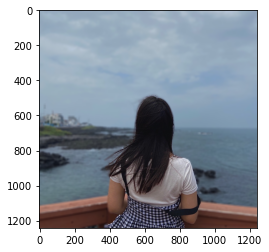

In [11]:
# 흐린 배경과 원본 사진 합성하기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 사진2 : 고양이

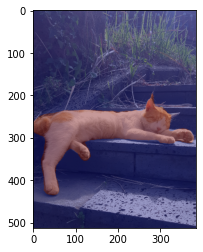

In [12]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

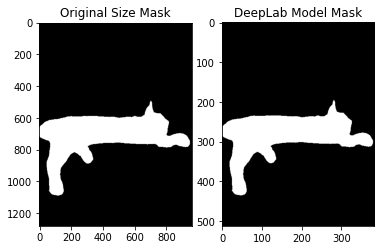

In [13]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

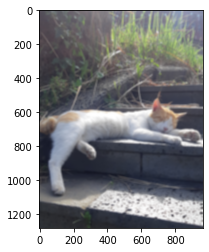

In [14]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

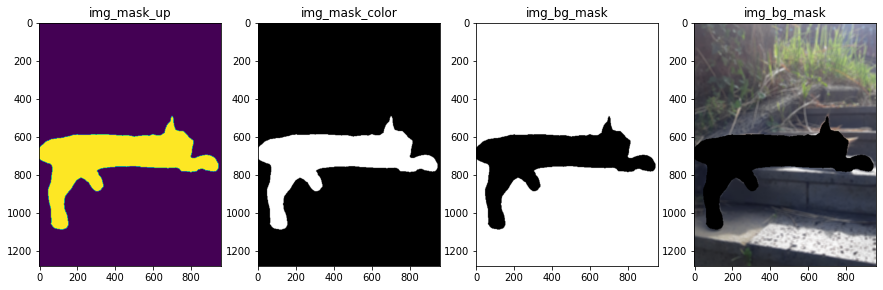

In [15]:
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

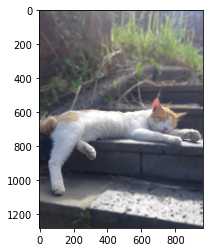

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 사진3: 인물 사진, 배경 합성 (제니..❤)

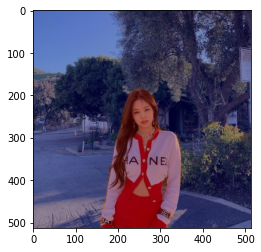

In [36]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jennie_image2.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

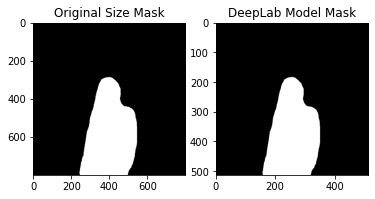

In [37]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

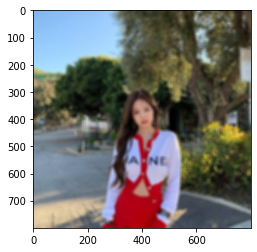

In [38]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

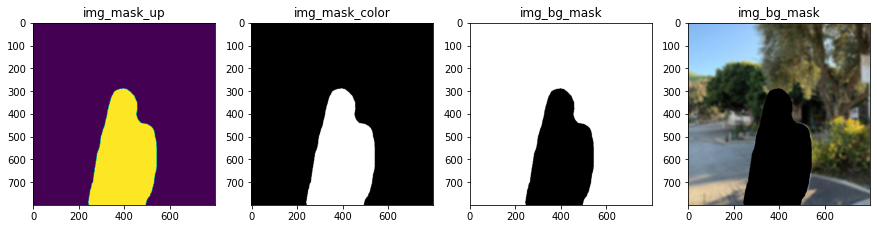

In [39]:
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

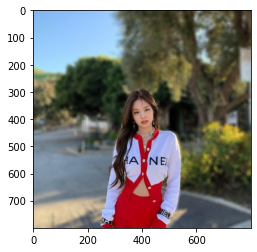

In [40]:
### 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

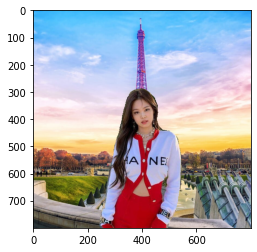

In [44]:
# 배경 합성


img_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/paris.jpg'
img_bg_orig = cv2.imread(img_bg_path) 
img_cropped_bg_orig = img_bg_orig

img_concat = np.where(img_mask_color==255, img_orig, img_cropped_bg_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점

머리카락의 일부분은 추출되지 않았다.
팔 사이이의 배경부분도 추출되어 블러처리가 되지 않았다.

## 해결방안

조명이나 색상, gray scale등 을 활용해서 object와 배경 사이의 차이를 확실하게 해준다면, 추출 성능이 크게 올라갈 것이다.